In [1]:
print("Installing libraries...")
# Force Pillow to be version 9.4.0 (known to be compatible)
!pip install Pillow==9.4.0 --force-reinstall -q 
!pip install "git+https://github.com/facebookresearch/detectron2.git" -q
!pip install layoutparser[layoutmodels] -q
# Ensure numpy is compatible
!pip install "numpy<1.26.4" --force-reinstall -q
print("Library installation complete.")

Installing libraries...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.17.0 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.2 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.4.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is i

In [2]:
import os
import requests

config_url = "https://huggingface.co/nlpconnect/PubLayNet-faster_rcnn_R_50_FPN_3x/resolve/main/config.yml"
weights_url = "https://huggingface.co/nlpconnect/PubLayNet-faster_rcnn_R_50_FPN_3x/resolve/main/model_final.pth"
config_path = "config.yml"
weights_path = "model_final.pth"

def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() 
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {filename} successfully.")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {filename}: {e}")
            return False
    else:
        print(f"{filename} already exists.")
    return os.path.exists(filename)

model_files_ready = download_file(config_url, config_path) and download_file(weights_url, weights_path)

if not model_files_ready:
    print("Model download failed. Cannot proceed with training.")
else:
    print("Pre-trained model files for fine-tuning are ready.")

config.yml already exists.
model_final.pth already exists.
Pre-trained model files for fine-tuning are ready.


In [3]:
import os
import json
import glob
import shutil
import cv2
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# --- FIX: Disable TensorFlow GPU usage ---
# This must be run BEFORE any detectron2/torch imports.
try:
    import tensorflow as tf
    tf.config.set_visible_devices([], 'GPU')
    print("Successfully disabled TensorFlow GPU usage.")
except (ImportError, Exception):
    print("TensorFlow not found or error disabling GPU, proceeding...")
# -----------------------------------------

# Detectron2 specific imports
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.model_zoo import model_zoo
from detectron2.utils import comm # Import for distributed training utils
from detectron2.utils.events import EventStorage
import logging

print("All libraries imported.")

2025-10-23 09:59:11.473659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761213551.496575     447 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761213551.503314     447 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Successfully disabled TensorFlow GPU usage.
All libraries imported.


In [4]:
# --- 1. (!!) USER MUST EDIT THESE PATHS (!!) ---
# Path to the directory containing all 4000 source images
SOURCE_IMAGE_DIR = "/kaggle/input/traindata/train/" 

# Path to the directory containing all 4000 corresponding ground truth JSON files
SOURCE_JSON_DIR = "/kaggle/input/trainjsongiven/trainjsonDPIIT/" # <--!! UPDATE THIS PATH
# --------------------------------------------------



# --- 2. Output Directories (These will be created) ---
BASE_OUTPUT_DIR = "/kaggle/working/dpiit_coco/"
TRAIN_IMG_DIR = os.path.join(BASE_OUTPUT_DIR, "images/train")
VAL_IMG_DIR = os.path.join(BASE_OUTPUT_DIR, "images/val")
ANNOTATION_DIR = os.path.join(BASE_OUTPUT_DIR, "annotations")
TRAIN_JSON_PATH = os.path.join(ANNOTATION_DIR, "instances_train.json")
VAL_JSON_PATH = os.path.join(ANNOTATION_DIR, "instances_val.json")
FINETUNE_OUTPUT_DIR = "/kaggle/working/output_finetune/"


# --- 3. Category Mappings (as per instructions) ---
# We are only interested in IDs 1, 2, and 5 from the source data
# We will remap them to 0, 1, and 2 for a 3-class model
OLD_ID_TO_NEW_ID = {
    1: 0, # Text
    2: 1, # Title
    5: 2  # Figure
}

# The new category definition for our combined COCO JSON
COCO_CATEGORIES = [
    {"id": 0, "name": "Text"},
    {"id": 1, "name": "Title"},
    {"id": 2, "name": "Figure"}
]
NUM_CLASSES = len(COCO_CATEGORIES)

print(f"Source Image Dir: {SOURCE_IMAGE_DIR}")
print(f"Source JSON Dir: {SOURCE_JSON_DIR}")
print(f"Output COCO Dir: {BASE_OUTPUT_DIR}")
print(f"New categories (Num Classes = {NUM_CLASSES}): {COCO_CATEGORIES}")

Source Image Dir: /kaggle/input/traindata/train/
Source JSON Dir: /kaggle/input/trainjsongiven/trainjsonDPIIT/
Output COCO Dir: /kaggle/working/dpiit_coco/
New categories (Num Classes = 3): [{'id': 0, 'name': 'Text'}, {'id': 1, 'name': 'Title'}, {'id': 2, 'name': 'Figure'}]


In [5]:
print("Creating directory structure...")
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(VAL_IMG_DIR, exist_ok=True)
os.makedirs(ANNOTATION_DIR, exist_ok=True)
os.makedirs(FINETUNE_OUTPUT_DIR, exist_ok=True)
print("Directory structure created.")

Creating directory structure...
Directory structure created.


In [6]:
all_json_files = sorted(glob.glob(os.path.join(SOURCE_JSON_DIR, "*.json")))

if not all_json_files:
    print(f"Error: No JSON files found in {SOURCE_JSON_DIR}. Please check your path in Cell 4.")
else:
    print(f"Found {len(all_json_files)} total JSON files.")
    
    # Split the files
    train_files, val_files = train_test_split(all_json_files, test_size=0.2, random_state=42)
    
    print(f"Training split: {len(train_files)} files")
    print(f"Validation split: {len(val_files)} files")

Found 4000 total JSON files.
Training split: 3200 files
Validation split: 800 files


In [7]:
def create_combined_coco_json(file_list, source_img_dir, output_img_dir, output_json_path, categories_map, new_categories_list):
    """
    Combines individual per-image JSONs into a single COCO-format JSON.
    Also copies the images to the new train/val directory.
    """
    
    # Initialize the COCO JSON structure
    combined_data = {
        "info": {"description": "Dpiit Fintetuning Dataset"},
        "licenses": [],
        "categories": new_categories_list,
        "images": [],
        "annotations": []
    }
    
    current_image_id = 1
    current_annot_id = 1
    
    print(f"Processing {len(file_list)} files for {output_json_path}...")
    
    for json_path in tqdm(file_list):
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            filename = data["file_name"]
            source_img_path = os.path.join(source_img_dir, filename)
            dest_img_path = os.path.join(output_img_dir, filename)
            
            # 1. Check if image exists
            if not os.path.exists(source_img_path):
                print(f"Warning: Image file not found, skipping: {source_img_path}")
                continue
                
            # 2. Copy image to new directory
            shutil.copy(source_img_path, dest_img_path)
            
            # 3. Get image dimensions
            try:
                height, width = cv2.imread(dest_img_path).shape[:2]
            except Exception as e:
                print(f"Warning: Could not read image, skipping: {dest_img_path}. Error: {e}")
                continue

            # 4. Add image entry
            image_entry = {
                "id": current_image_id,
                "file_name": filename,
                "height": height,
                "width": width
            }
            combined_data["images"].append(image_entry)
            
            # 5. Process and remap annotations
            for ann in data["annotations"]:
                old_cat_id = ann["category_id"]
                
                # Only include categories we care about
                if old_cat_id in categories_map:
                    new_cat_id = categories_map[old_cat_id]
                    
                    bbox = ann["bbox"] # Assuming [x, y, w, h]
                    area = bbox[2] * bbox[3]
                    
                    annot_entry = {
                        "id": current_annot_id,
                        "image_id": current_image_id,
                        "category_id": new_cat_id,
                        "bbox": bbox,
                        "area": area,
                        "iscrowd": 0,
                        "segmentation": [] # Assuming no segmentation
                    }
                    combined_data["annotations"].append(annot_entry)
                    current_annot_id += 1
                    
            current_image_id += 1
            
        except Exception as e:
            print(f"Error processing file {json_path}: {e}")
            
    # 6. Save the combined JSON file
    with open(output_json_path, 'w') as f:
        json.dump(combined_data, f)
        
    print(f"Successfully created {output_json_path}")
    print(f"Total images: {len(combined_data['images'])}")
    print(f"Total annotations: {len(combined_data['annotations'])}")


# --- Run the data preparation ---
if 'train_files' in locals() and 'val_files' in locals():
    # Process training data
    create_combined_coco_json(train_files, SOURCE_IMAGE_DIR, TRAIN_IMG_DIR, TRAIN_JSON_PATH, OLD_ID_TO_NEW_ID, COCO_CATEGORIES)
    
    # Process validation data
    create_combined_coco_json(val_files, SOURCE_IMAGE_DIR, VAL_IMG_DIR, VAL_JSON_PATH, OLD_ID_TO_NEW_ID, COCO_CATEGORIES)
else:
    print("Error: train_files or val_files not defined. Run Cell 6 first.")

Processing 3200 files for /kaggle/working/dpiit_coco/annotations/instances_train.json...


  0%|          | 0/3200 [00:00<?, ?it/s]

Successfully created /kaggle/working/dpiit_coco/annotations/instances_train.json
Total images: 3200
Total annotations: 31043
Processing 800 files for /kaggle/working/dpiit_coco/annotations/instances_val.json...


  0%|          | 0/800 [00:00<?, ?it/s]

Successfully created /kaggle/working/dpiit_coco/annotations/instances_val.json
Total images: 800
Total annotations: 7721


In [8]:
print("Registering datasets with Detectron2...")

try:
    MetadataCatalog.remove("dpiit_train")
    MetadataCatalog.remove("dpiit_val")
    DatasetCatalog.remove("dpiit_train")
    DatasetCatalog.remove("dpiit_val")
except KeyError:
    pass 

register_coco_instances("dpiit_train", {}, TRAIN_JSON_PATH, TRAIN_IMG_DIR)
register_coco_instances("dpiit_val", {}, VAL_JSON_PATH, VAL_IMG_DIR)

print("Datasets registered.")
print("\nTraining Metadata:")
print(MetadataCatalog.get("dpiit_train"))
print("\nValidation Metadata:")
print(MetadataCatalog.get("dpiit_val"))

Registering datasets with Detectron2...
Datasets registered.

Training Metadata:
Metadata(name='dpiit_train', json_file='/kaggle/working/dpiit_coco/annotations/instances_train.json', image_root='/kaggle/working/dpiit_coco/images/train', evaluator_type='coco')

Validation Metadata:
Metadata(name='dpiit_val', json_file='/kaggle/working/dpiit_coco/annotations/instances_val.json', image_root='/kaggle/working/dpiit_coco/images/val', evaluator_type='coco')


In [14]:
%%writefile /kaggle/working/train_script.py

# === Imports (from Cell 3) ===
import os
import logging
from tqdm import tqdm # Use standard tqdm for scripts
import torch

# --- FIX: Disable TensorFlow GPU usage ---
try:
    import tensorflow as tf
    tf.config.set_visible_devices([], 'GPU')
    print("Script: Successfully disabled TensorFlow GPU usage.")
except (ImportError, Exception):
    print("Script: TensorFlow not found or error disabling GPU, proceeding...")

from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.utils import comm
from detectron2.utils.events import EventStorage

# === Paths & Mappings (Hardcoded from Cell 4) ===
# These must be defined again for the new process
TRAIN_JSON_PATH = "/kaggle/working/dpiit_coco/annotations/instances_train.json"
TRAIN_IMG_DIR = "/kaggle/working/dpiit_coco/images/train"
VAL_JSON_PATH = "/kaggle/working/dpiit_coco/annotations/instances_val.json"
VAL_IMG_DIR = "/kaggle/working/dpiit_coco/images/val"
FINETUNE_OUTPUT_DIR = "/kaggle/working/output_finetune/"
NUM_CLASSES = 3 # From Cell 4

# === Trainer Class (with tqdm for main process) ===
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_eval")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def train(self):
        logger = logging.getLogger("detectron2")
        logger.info("Starting training from iteration {}".format(self.start_iter))
        is_main_process = comm.is_main_process()

        with EventStorage(self.start_iter) as self.storage:
            try:
                self.before_train()
                pbar = None
                if is_main_process:
                    pbar = tqdm(range(self.start_iter, self.max_iter), 
                                desc="Training Progress", 
                                initial=self.start_iter, 
                                total=self.max_iter)

                for self.iter in range(self.start_iter, self.max_iter):
                    self.before_step()
                    self.run_step() 
                    self.after_step()
                    
                    if pbar is not None and (self.iter % 20 == 0 or self.iter == self.max_iter - 1):
                        loss_dict = self.storage.latest()
                        if "total_loss" in loss_dict:
                            pbar.set_description(f"Iter: {self.iter} | Loss: {loss_dict['total_loss'][0]:.4f}")
                            pbar.update(self.iter - pbar.n) 
                
                if pbar is not None:
                    pbar.update(self.max_iter - pbar.n)
                    pbar.close()
                         
            except Exception:
                logger.exception("Exception during training:")
                raise
            finally:
                self.after_train()

# === Config Setup (from old Cell 9) ===
def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file("/kaggle/working/config.yml") # Use absolute path
    cfg.MODEL.WEIGHTS = "/kaggle/working/model_final.pth" # Use absolute path
    cfg.DATASETS.TRAIN = ("dpiit_train",)
    cfg.DATASETS.TEST = ("dpiit_val",)
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
    cfg.SOLVER.IMS_PER_BATCH = 2 # This is PER GPU (total batch size = 4)
    cfg.SOLVER.BASE_LR = 0.0005  # Scaled LR for 2 GPUs
    cfg.SOLVER.MAX_ITER = 30000    
    cfg.SOLVER.STEPS = (15000, 25000)
    cfg.SOLVER.GAMMA = 0.1         
    cfg.SOLVER.CHECKPOINT_PERIOD = 5000 
    cfg.OUTPUT_DIR = FINETUNE_OUTPUT_DIR
    cfg.TEST.EVAL_PERIOD = 5000
    return cfg

# === Main Function (to be called by launch) ===
def main(args=None):
    
    # Register datasets *in this process* (CRITICAL FIX)
    try:
        register_coco_instances("dpiit_train", {}, TRAIN_JSON_PATH, TRAIN_IMG_DIR)
        register_coco_instances("dpiit_val", {}, VAL_JSON_PATH, VAL_IMG_DIR)
    except AssertionError:
         if comm.is_main_process():
             print("Script: Datasets already registered, proceeding.")
    
    cfg = setup_cfg()
    
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False) 
    trainer.train()

# === Launch block ===
if __name__ == "__main__":
    print("Train script starting...")
    
    # Check for model files
    model_files_ready = os.path.exists("/kaggle/working/config.yml") and os.path.exists("/kaggle/working/model_final.pth")
    if not model_files_ready:
        print("Error: Model files (config.yml, model_final.pth) not found in /kaggle/working/")
    else:
        # Set environment variables
        os.environ["MASTER_ADDR"] = "localhost"
        os.environ["MASTER_PORT"] = "12355"
        
        print("Launching 2-GPU training...")
        try:
            launch(
                main,
                num_gpus_per_machine=2,
                dist_url="env://",
                args=()
            )
        except Exception as e:
            print(f"Training launch failed: {e}")
        
        print("Training launch process complete.")

Overwriting /kaggle/working/train_script.py


In [15]:
# === Step 7: Launch 2-GPU Training ===
# This cell executes the script we wrote in Cell 9

# Check if model files are ready before trying to train
if model_files_ready:
    print("Executing train_script.py...")
    !python /kaggle/working/train_script.py
    print("\nTraining complete.")
else:
    print("Cannot start training: pre-trained model files are missing. Run Cell 2.")

Executing train_script.py...
2025-10-23 10:17:23.020846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761214643.043252     934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761214643.050232     934 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Script: Successfully disabled TensorFlow GPU usage.
Train script starting...
Launching 2-GPU training...
2025-10-23 10:17:30.640837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761214650.662605     951 cuda_dnn.cc:8310] Unable to register cuDNN factory: Att

In [16]:
print("Starting final evaluation on validation set...")
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor

# --- We need to define setup_cfg again for this notebook cell ---
def setup_cfg_eval():
    cfg = get_cfg()
    cfg.merge_from_file("/kaggle/working/config.yml") 
    cfg.DATASETS.TEST = ("dpiit_val",)
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
    cfg.OUTPUT_DIR = FINETUNE_OUTPUT_DIR
    return cfg
# -------------------------------------------------------------

# 1. Update config to use the *newly trained* weights
eval_cfg = setup_cfg_eval() 
eval_cfg.MODEL.WEIGHTS = os.path.join(eval_cfg.OUTPUT_DIR, "model_final.pth")
eval_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

# 3. Create a predictor and evaluator
try:
    predictor = DefaultPredictor(eval_cfg)
    evaluator = COCOEvaluator("dpiit_val", eval_cfg, False, output_dir=os.path.join(eval_cfg.OUTPUT_DIR, "final_eval"))
    val_loader = build_detection_test_loader(eval_cfg, "dpiit_val")
    
    # 4. Run inference
    eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
    
    print("\n--- Final Evaluation Results ---")
    print(eval_results)
    print("---------------------------------")
    
except Exception as e:
    print(f"Error during evaluation: {e}")
    print("This can sometimes happen if training did not complete successfully or no model_final.pth was saved.")

print("Evaluation complete.")

Starting final evaluation on validation set...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.899
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.890
 Average Recall     (AR) @[ IoU=0.50:0.

In [17]:
print("Starting final evaluation on validation set...")
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor

# --- We need to define setup_cfg again for this notebook cell ---
def setup_cfg_eval():
    cfg = get_cfg()
    cfg.merge_from_file("/kaggle/working/config.yml") 
    cfg.DATASETS.TEST = ("dpiit_val",)
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
    cfg.OUTPUT_DIR = FINETUNE_OUTPUT_DIR
    return cfg
# -------------------------------------------------------------

# 1. Update config to use the *newly trained* weights
eval_cfg = setup_cfg_eval() 
eval_cfg.MODEL.WEIGHTS = os.path.join(eval_cfg.OUTPUT_DIR, "/kaggle/working/output_finetune/model_0019999.pth")
eval_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

# 3. Create a predictor and evaluator
try:
    predictor = DefaultPredictor(eval_cfg)
    evaluator = COCOEvaluator("dpiit_val", eval_cfg, False, output_dir=os.path.join(eval_cfg.OUTPUT_DIR, "final_eval"))
    val_loader = build_detection_test_loader(eval_cfg, "dpiit_val")
    
    # 4. Run inference
    eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
    
    print("\n--- Final Evaluation Results ---")
    print(eval_results)
    print("---------------------------------")
    
except Exception as e:
    print(f"Error during evaluation: {e}")
    print("This can sometimes happen if training did not complete successfully or no model_final.pth was saved.")

print("Evaluation complete.")

Starting final evaluation on validation set...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.872
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.887
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] 

In [18]:
print("Starting final evaluation on validation set...")
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor

# --- We need to define setup_cfg again for this notebook cell ---
def setup_cfg_eval():
    cfg = get_cfg()
    cfg.merge_from_file("/kaggle/working/config.yml") 
    cfg.DATASETS.TEST = ("dpiit_val",)
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
    cfg.OUTPUT_DIR = FINETUNE_OUTPUT_DIR
    return cfg
# -------------------------------------------------------------

# 1. Update config to use the *newly trained* weights
eval_cfg = setup_cfg_eval() 
eval_cfg.MODEL.WEIGHTS = os.path.join(eval_cfg.OUTPUT_DIR, "/kaggle/working/output_finetune/model_0024999.pth")
eval_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

# 3. Create a predictor and evaluator
try:
    predictor = DefaultPredictor(eval_cfg)
    evaluator = COCOEvaluator("dpiit_val", eval_cfg, False, output_dir=os.path.join(eval_cfg.OUTPUT_DIR, "final_eval"))
    val_loader = build_detection_test_loader(eval_cfg, "dpiit_val")
    
    # 4. Run inference
    eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
    
    print("\n--- Final Evaluation Results ---")
    print(eval_results)
    print("---------------------------------")
    
except Exception as e:
    print(f"Error during evaluation: {e}")
    print("This can sometimes happen if training did not complete successfully or no model_final.pth was saved.")

print("Evaluation complete.")

Starting final evaluation on validation set...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.899
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] 

Showing predictions for: /kaggle/input/testdata/MOCK_DATA/documents/doc_00090.png


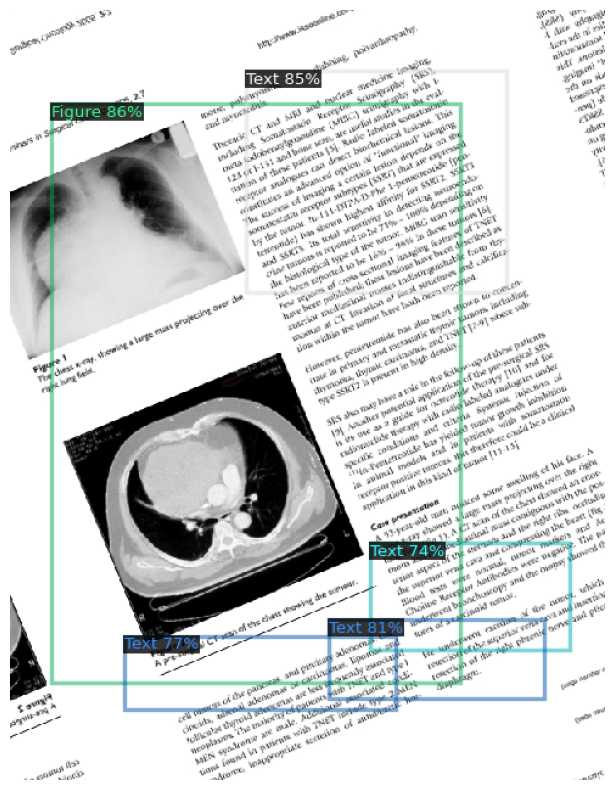

In [22]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

# 1. Load the fine-tuned model
eval_cfg = setup_cfg()
eval_cfg.MODEL.WEIGHTS = os.path.join(FINETUNE_OUTPUT_DIR, "/kaggle/working/output_finetune/model_0019999.pth")
eval_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a threshold
predictor = DefaultPredictor(eval_cfg)

# 2. Get the metadata for our dataset (for class names)
val_metadata = MetadataCatalog.get("dpiit_val")

# 3. Load a validation image
# Find one of the validation images we copied earlier
val_image_path = "/kaggle/input/testdata/MOCK_DATA/documents/doc_00090.png" # Get the first one
im = cv2.imread(val_image_path)

# 4. Run prediction
outputs = predictor(im)

# 5. Visualize
v = Visualizer(im[:, :, ::-1],
               metadata=val_metadata, 
               scale=0.8
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# 6. Show image
print(f"Showing predictions for: {val_image_path}")
plt.figure(figsize=(14, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()


Detected angle: -22.03 degrees. Rotating...


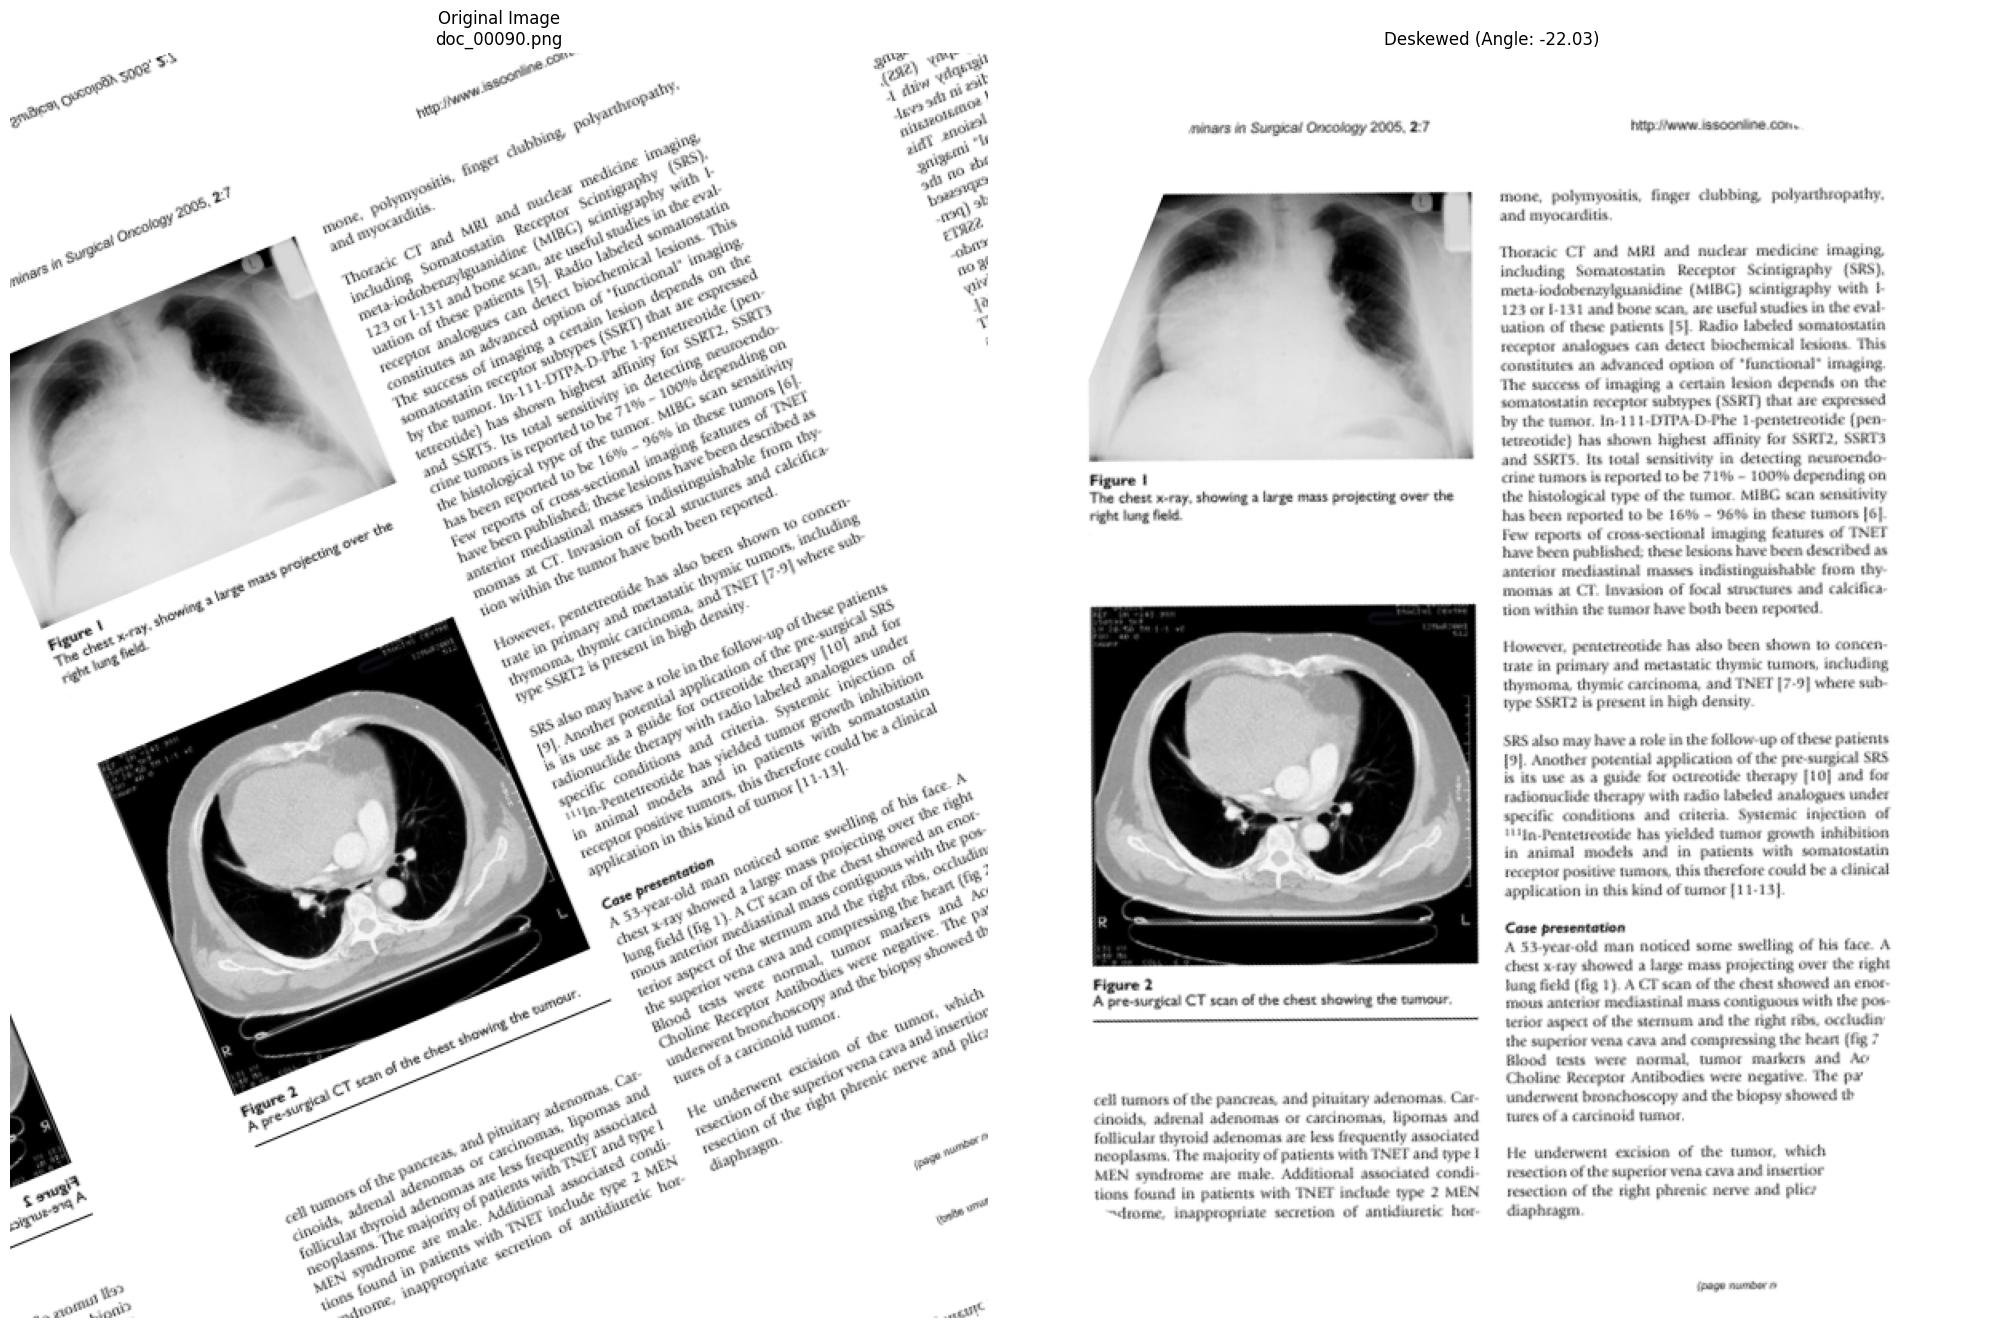

In [23]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# --- !!! USER: EDIT THIS PATH !!! ---
# Path to a single SKEWED image you want to test
TEST_IMAGE_PATH = "/kaggle/input/testdata/MOCK_DATA/documents/doc_00090.png"
# ------------------------------------

# === DESKEW FUNCTION ===
def deskew_image_hough(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray) # Invert colors for Hough transform
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)

    if lines is None or len(lines) == 0:
         edges = cv2.Canny(gray, 50, 150, apertureSize=3)
         lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)
         if lines is None or len(lines) == 0:
             print("No lines found, returning original image.")
             return image_bgr, 0.0

    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 != 0:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            if -45 < angle < 45:
                    angles.append(angle)

    if not angles:
         print("No valid angles found, returning original image.")
         return image_bgr, 0.0

    median_angle = np.median(angles)
    
    if abs(median_angle) < 0.5:
         print(f"Angle {median_angle:.2f} is too small, returning original image.")
         return image_bgr, 0.0
    
    print(f"Detected angle: {median_angle:.2f} degrees. Rotating...")

    (h, w) = image_bgr.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    
    rotated_bgr = cv2.warpAffine(image_bgr, M, (w, h),
                                 flags=cv2.INTER_CUBIC, 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
    
    return rotated_bgr, median_angle
# === END OF DESKEW FUNCTION ===

# --- Load and Test ---
if not os.path.exists(TEST_IMAGE_PATH):
    print(f"Error: Test image not found at {TEST_IMAGE_PATH}. Please check the path.")
else:
    im_original = cv2.imread(TEST_IMAGE_PATH)
    
    # Run the deskew logic
    im_deskewed, angle = deskew_image_hough(im_original)
    
    # --- Display side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 15))
    
    # Original
    axes[0].imshow(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image\n{os.path.basename(TEST_IMAGE_PATH)}")
    axes[0].axis('off')
    
    # Deskewed
    axes[1].imshow(cv2.cvtColor(im_deskewed, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Deskewed (Angle: {angle:.2f})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Model loaded successfully.
Detected angle: 2.99 degrees. Rotating...
Running prediction...
Found 5 instances.


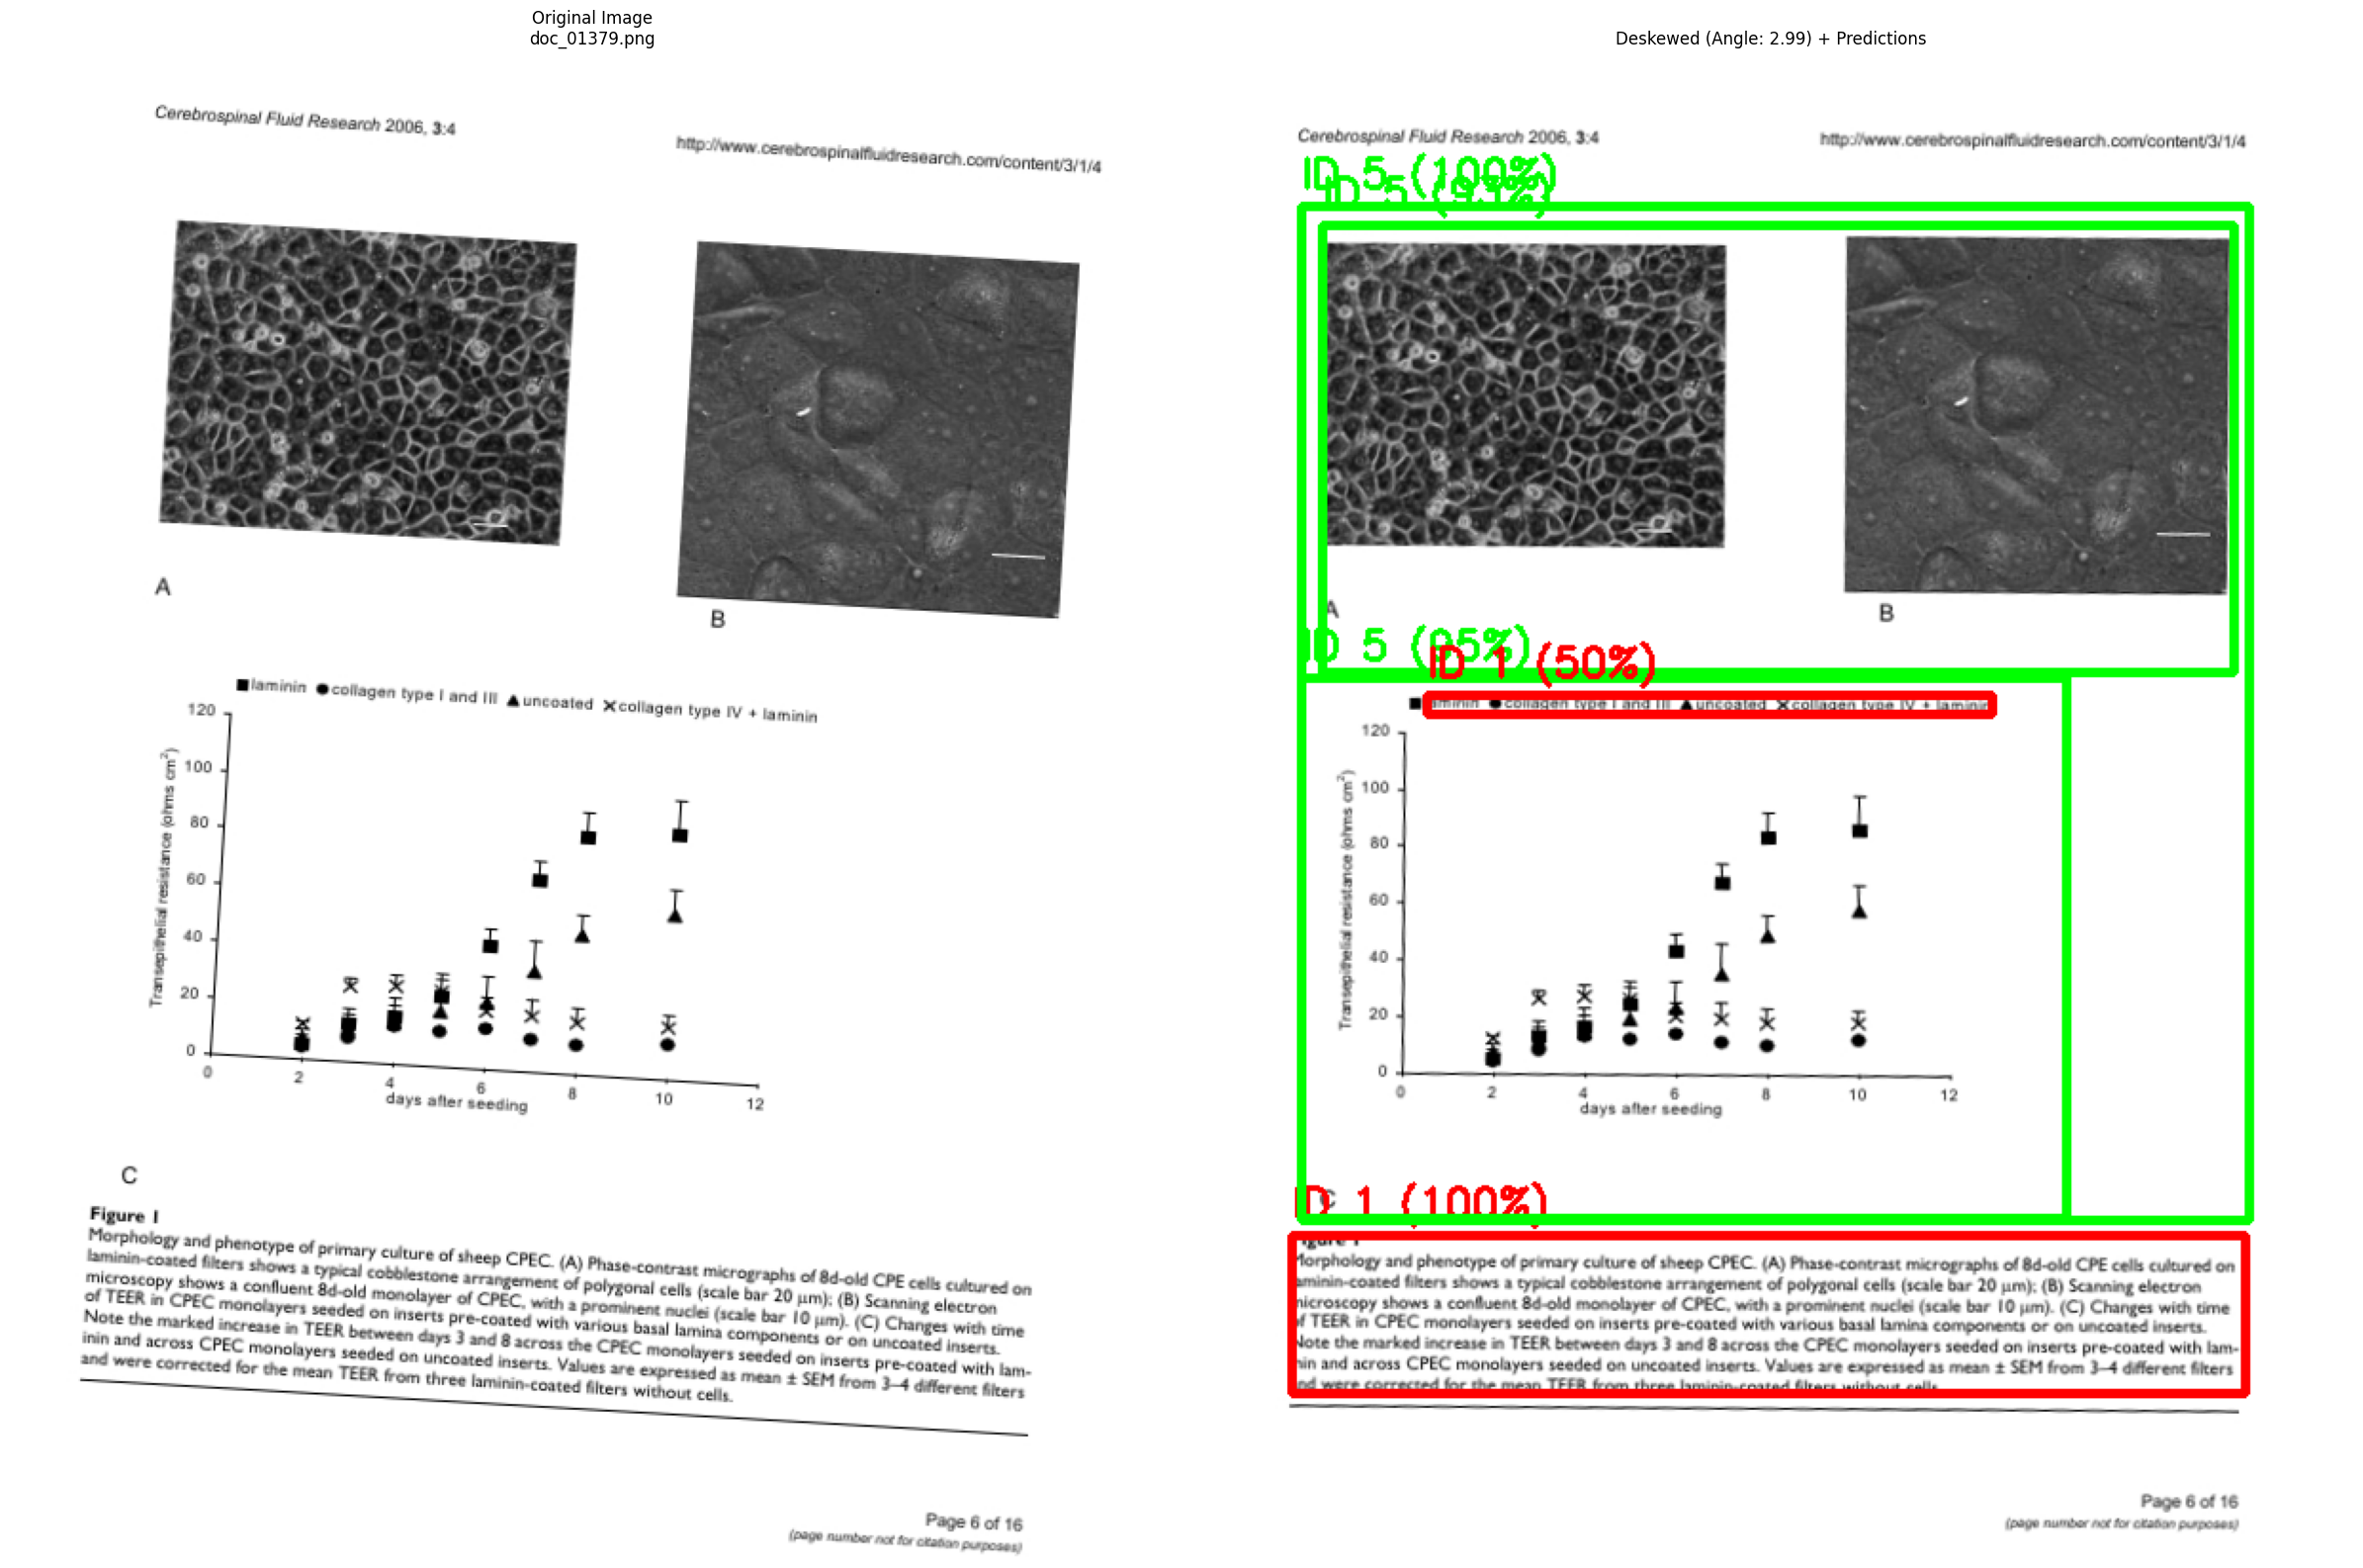

In [25]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog

# --- !!! USER: EDIT THIS PATH !!! ---
# Path to a single SKEWED image you want to test
TEST_IMAGE_PATH = "/kaggle/input/testdata/MOCK_DATA/documents/doc_01379.png"
# ------------------------------------

# === Model & Config Paths ===
CONFIG_FILE_PATH = "/kaggle/working/config.yml"
MODEL_WEIGHTS_PATH = "/kaggle/working/output_finetune/model_0019999.pth"
NUM_CLASSES = 3
CONFIDENCE_THRESHOLD = 0.5

# === Mappings ===
MODEL_CLASS_TO_SUBMISSION_ID = {
    0: 1,  # Text
    1: 2,  # Title
    2: 5   # Figure
}
SUBMISSION_ID_TO_COLOR_BGR = {
    1: (0, 0, 255),  # Red for Text
    2: (255, 0, 0),  # Blue for Title
    5: (0, 255, 0)   # Green for Figure
}
DEFAULT_COLOR_BGR = (255, 255, 255) # White

# === DESKEW FUNCTION ===
def deskew_image_hough(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)

    if lines is None or len(lines) == 0:
         edges = cv2.Canny(gray, 50, 150, apertureSize=3)
         lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)
         if lines is None or len(lines) == 0:
             print("No lines found, returning original image.")
             return image_bgr, 0.0

    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 != 0:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            if -45 < angle < 45:
                    angles.append(angle)

    if not angles:
         print("No valid angles found, returning original image.")
         return image_bgr, 0.0

    median_angle = np.median(angles)
    
    if abs(median_angle) < 0.5:
         print(f"Angle {median_angle:.2f} is too small, returning original image.")
         return image_bgr, 0.0
    
    print(f"Detected angle: {median_angle:.2f} degrees. Rotating...")
    (h, w) = image_bgr.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated_bgr = cv2.warpAffine(image_bgr, M, (w, h),
                                 flags=cv2.INTER_CUBIC, 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
    return rotated_bgr, median_angle
# === END OF DESKEW FUNCTION ===


# --- Load and Test ---
if not os.path.exists(TEST_IMAGE_PATH):
    print(f"Error: Test image not found at {TEST_IMAGE_PATH}. Please check the path.")
elif not os.path.exists(MODEL_WEIGHTS_PATH):
    print(f"Error: Model not found at {MODEL_WEIGHTS_PATH}. Please run training first.")
else:
    # --- 1. Load Model ---
    pred_cfg = get_cfg()
    pred_cfg.merge_from_file(CONFIG_FILE_PATH)
    pred_cfg.MODEL.WEIGHTS = MODEL_WEIGHTS_PATH
    pred_cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
    pred_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CONFIDENCE_THRESHOLD
    pred_cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    predictor = DefaultPredictor(pred_cfg)
    print("Model loaded successfully.")

    # --- 2. Load and Deskew Image ---
    im_original = cv2.imread(TEST_IMAGE_PATH)
    im_deskewed, angle = deskew_image_hough(im_original)
    
    # Create a copy to draw on
    im_annotated = im_deskewed.copy()

    # --- 3. Run Prediction on Deskewed Image ---
    print("Running prediction...")
    outputs = predictor(im_deskewed)
    instances = outputs["instances"].to("cpu")
    
    boxes = instances.pred_boxes.tensor.numpy()
    pred_classes = instances.pred_classes.numpy()
    scores = instances.scores.numpy()
    
    print(f"Found {len(boxes)} instances.")

    # --- 4. Draw Bounding Boxes ---
    for box, model_class_id, score in zip(boxes, pred_classes, scores):
        submission_cat_id = MODEL_CLASS_TO_SUBMISSION_ID.get(int(model_class_id))
        
        if submission_cat_id is None:
            continue
            
        x1, y1, x2, y2 = [int(b) for b in box]
        color = SUBMISSION_ID_TO_COLOR_BGR.get(submission_cat_id, DEFAULT_COLOR_BGR)
        
        # Draw rectangle and label
        cv2.rectangle(im_annotated, (x1, y1), (x2, y2), color, 3)
        label = f"ID {submission_cat_id} ({score*100:.0f}%)"
        cv2.putText(im_annotated, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # --- 5. Display Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(24, 18))
    
    # Original
    axes[0].imshow(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image\n{os.path.basename(TEST_IMAGE_PATH)}")
    axes[0].axis('off')
    
    # Deskewed + Annotated
    axes[1].imshow(cv2.cvtColor(im_annotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Deskewed (Angle: {angle:.2f}) + Predictions")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
# === Step 12: Run Inference, Deskew, and Zip Results ===

print("Starting inference on new images...")
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import glob
import cv2
import os
from tqdm.notebook import tqdm
import json
import torch
import math
import numpy as np
import shutil # <-- Added import for zipping

# --- !!! USER: EDIT THIS PATH !!! ---
# Path to the directory containing your 1000 new images
INPUT_IMAGE_DIR = "/kaggle/input/testdata/MOCK_DATA/documents/" # <--!! UPDATE THIS PATH
# ------------------------------------

# --- Output Directories ---
OUTPUT_JSON_DIR = "/kaggle/working/submission_mAP-0.951/"
OUTPUT_ZIP_FILE = "/kaggle/working/submission_mAP-0.951.zip" # <-- Added zip file path
os.makedirs(OUTPUT_JSON_DIR, exist_ok=True)

# --- Mappings ---
MODEL_CLASS_MAP = {
    0: {"id": 1, "name": "Text"},   # Model class 0 -> Submission ID 1
    1: {"id": 2, "name": "Title"},  # Model class 1 -> Submission ID 2
    2: {"id": 5, "name": "Figure"}  # Model class 2 -> Submission ID 5
}

# === ADDED DESKEW FUNCTION ===
def deskew_image_hough(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray) # Invert colors for Hough transform
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)

    if lines is None or len(lines) == 0:
         edges = cv2.Canny(gray, 50, 150, apertureSize=3)
         lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)
         if lines is None or len(lines) == 0:
             return image_bgr, 0.0 # Return original if still no lines

    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 != 0: # Avoid division by zero
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            if -45 < angle < 45: # Focus on angles within a reasonable range
                    angles.append(angle)

    if not angles:
         return image_bgr, 0.0 # Return original if no valid angles

    median_angle = np.median(angles)
    
    if abs(median_angle) < 0.5:
         return image_bgr, 0.0

    (h, w) = image_bgr.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    
    rotated_bgr = cv2.warpAffine(image_bgr, M, (w, h),
                                 flags=cv2.INTER_CUBIC, 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
    
    return rotated_bgr, median_angle
# === END OF DESKEW FUNCTION ===


# --- Load the Fine-Tuned Model ---
pred_cfg = get_cfg()
pred_cfg.merge_from_file("/kaggle/working/config.yml")
pred_cfg.MODEL.WEIGHTS = "/kaggle/working/output_finetune/model_0019999.pth" # Using your best model
pred_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
pred_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
pred_cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(pred_cfg)
print("Model model_0019999.pth loaded successfully.")

# --- Run Inference Loop ---
print(f"Looking for images in: {INPUT_IMAGE_DIR}")
image_paths = glob.glob(os.path.join(INPUT_IMAGE_DIR, "*.[jp][pn]g")) + \
              glob.glob(os.path.join(INPUT_IMAGE_DIR, "*.jpeg"))

if not image_paths:
    print(f"Error: No images found in {INPUT_IMAGE_DIR}. Please check your path.")
else:
    for image_path in tqdm(image_paths, desc="Processing Images"):
        try:
            im = cv2.imread(image_path)
            if im is None:
                print(f"Warning: Could not read image {image_path}, skipping.")
                continue

            im_deskewed, angle = deskew_image_hough(im)
            
            outputs = predictor(im_deskewed)
            
            instances = outputs["instances"].to("cpu")
            boxes = instances.pred_boxes.tensor.numpy()
            pred_classes = instances.pred_classes.numpy()
            scores = instances.scores.numpy()
            
            annotations = []
            
            for box, model_class_id, score in zip(boxes, pred_classes, scores):
                
                mapping = MODEL_CLASS_MAP.get(int(model_class_id))
                
                if mapping is None:
                    continue 
                
                x1, y1, x2, y2 = box
                bbox_coco = [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]
                
                annotations.append({
                    "bbox": bbox_coco,
                    "category_id": mapping["id"],
                    "category_name": mapping["name"],
                    "score": float(score)
                })

            base_filename = os.path.basename(image_path)
            json_filename = os.path.splitext(base_filename)[0] + ".json"
            output_path = os.path.join(OUTPUT_JSON_DIR, json_filename)
            
            output_data = {
                "file_name": base_filename, 
                "annotations": annotations
            }
            
            with open(output_path, 'w') as f:
                json.dump(output_data, f, indent=2)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            
    print(f"\nInference complete. {len(image_paths)} JSON files saved to: {OUTPUT_JSON_DIR}")

    # === Step 6: Zip the Output Folder ===
    print(f"Zipping the output folder '{os.path.basename(OUTPUT_JSON_DIR)}'...")
    try:
        shutil.make_archive(
            OUTPUT_ZIP_FILE.replace('.zip', ''), # Base name for zip
            'zip',                               # Format
            OUTPUT_JSON_DIR                      # Directory to zip
        )
        print(f"Successfully created zip file: {OUTPUT_ZIP_FILE}")
        print(f"\n---> You can now download '{os.path.basename(OUTPUT_ZIP_FILE)}' from the Kaggle 'Output' section.")
    except Exception as e:
        print(f"Error creating zip file: {e}")

Starting inference on new images...
Model model_0019999.pth loaded successfully.
Looking for images in: /kaggle/input/testdata/MOCK_DATA/documents/


Processing Images:   0%|          | 0/1000 [00:00<?, ?it/s]


Inference complete. 1000 JSON files saved to: /kaggle/working/submission_mAP-0.951/
Zipping the output folder ''...
Successfully created zip file: /kaggle/working/submission_mAP-0.951.zip

---> You can now download 'submission_mAP-0.951.zip' from the Kaggle 'Output' section.
